# COVID-19 পেপার বিশ্লেষণ

এই চ্যালেঞ্জে, আমরা COVID মহামারীর বিষয় নিয়ে কাজ চালিয়ে যাব এবং এই বিষয়ে বৈজ্ঞানিক পেপার প্রক্রিয়াকরণের উপর মনোযোগ কেন্দ্রীভূত করব। [CORD-19 Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)-এ ৭০০০-এরও বেশি (এই লেখার সময়) COVID সম্পর্কিত পেপার রয়েছে, যা মেটাডেটা এবং সারাংশসহ উপলব্ধ (এবং প্রায় অর্ধেকের জন্য সম্পূর্ণ টেক্সটও সরবরাহ করা হয়েছে)।

এই ডেটাসেট বিশ্লেষণের একটি পূর্ণাঙ্গ উদাহরণ [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) কগনিটিভ সার্ভিস ব্যবহার করে [এই ব্লগ পোস্টে](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) বর্ণনা করা হয়েছে। আমরা এই বিশ্লেষণের একটি সরলীকৃত সংস্করণ নিয়ে আলোচনা করব।


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## ডেটা সংগ্রহ করা

প্রথমে, আমাদের CORD পেপারগুলোর মেটাডেটা সংগ্রহ করতে হবে, যেগুলো নিয়ে আমরা কাজ করব।

**NOTE**: আমরা এই রিপোজিটরির অংশ হিসেবে ডেটাসেটের কোনো কপি সরবরাহ করি না। আপনাকে প্রথমে [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) ফাইলটি [এই Kaggle ডেটাসেট থেকে](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) ডাউনলোড করতে হতে পারে। Kaggle-এ নিবন্ধন প্রয়োজন হতে পারে। আপনি নিবন্ধন ছাড়াও [এখান থেকে](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html) ডেটাসেট ডাউনলোড করতে পারেন, তবে এটি মেটাডেটা ফাইলের পাশাপাশি সমস্ত পূর্ণ টেক্সট অন্তর্ভুক্ত করবে।

আমরা সরাসরি অনলাইন উৎস থেকে ডেটা সংগ্রহ করার চেষ্টা করব, তবে যদি এটি ব্যর্থ হয়, তাহলে আপনাকে উপরে বর্ণিত পদ্ধতি অনুযায়ী ডেটা ডাউনলোড করতে হবে। এছাড়াও, যদি আপনি ডেটার সাথে আরও পরীক্ষা-নিরীক্ষা করার পরিকল্পনা করেন, তাহলে ডেটা ডাউনলোড করাটা যুক্তিযুক্ত হবে, যাতে অপেক্ষার সময় বাঁচানো যায়।

> **NOTE** যে ডেটাসেটটি বেশ বড়, প্রায় ১ জিবি আকারের, এবং নিচের কোডের লাইনটি সম্পন্ন হতে অনেক সময় লাগতে পারে! (~৫ মিনিট)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

আমরা এখন প্রকাশনার তারিখ কলামটি `datetime` এ রূপান্তর করব এবং প্রকাশনার তারিখের পরিসর দেখতে হিস্টোগ্রাম আঁকব।


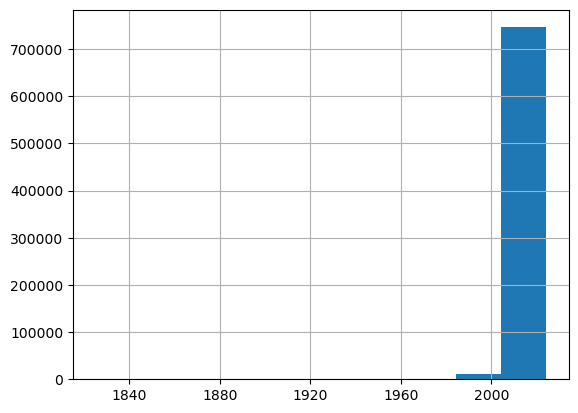

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## কাঠামোবদ্ধ ডেটা নিষ্কাশন

চলুন দেখি আমরা সারাংশ থেকে কী ধরনের তথ্য সহজেই বের করতে পারি। একটি বিষয় যা আমাদের আগ্রহের হতে পারে তা হলো কোন কোন চিকিৎসা কৌশল বিদ্যমান এবং সেগুলো কীভাবে সময়ের সাথে পরিবর্তিত হয়েছে। শুরুতে, আমরা ম্যানুয়ালি COVID চিকিৎসার জন্য ব্যবহৃত সম্ভাব্য ওষুধের একটি তালিকা এবং একইসাথে রোগ নির্ণয়ের একটি তালিকা তৈরি করতে পারি। এরপর আমরা এগুলো পর্যালোচনা করি এবং গবেষণাপত্রের সারাংশে সংশ্লিষ্ট শব্দগুলো খুঁজে বের করি।


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


আমরা আমাদের ডেটাফ্রেমে বেশ কিছু কলাম যোগ করেছি, যা একটি নির্দিষ্ট ওষুধ/রোগ নির্ণয়ের নাম কতবার অ্যাবস্ট্রাক্টে উপস্থিত রয়েছে তা দেখায়।

> **নোট করুন** যে আমরা সাবস্ট্রিং খোঁজার সময় শব্দের শুরুতে একটি স্পেস যোগ করি। যদি আমরা এটি না করি, তাহলে ভুল ফলাফল পেতে পারি, কারণ *chloroquine* সাবস্ট্রিং *hydroxychloroquine*-এর ভেতরেও পাওয়া যাবে। এছাড়াও, আমরা অ্যাবস্ট্রাক্ট কলামকে `str`-এ রূপান্তর করতে বাধ্য করি একটি ত্রুটি দূর করার জন্য - `str` সরিয়ে ফেলুন এবং দেখুন কী ঘটে।

ডেটার সাথে কাজ করা সহজ করতে, আমরা শুধুমাত্র ওষুধের গণনা সহ সাব-ফ্রেমটি বের করতে পারি এবং উপস্থিতির মোট সংখ্যা গণনা করতে পারি। এটি আমাদের সবচেয়ে জনপ্রিয় ওষুধটি দেয়:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

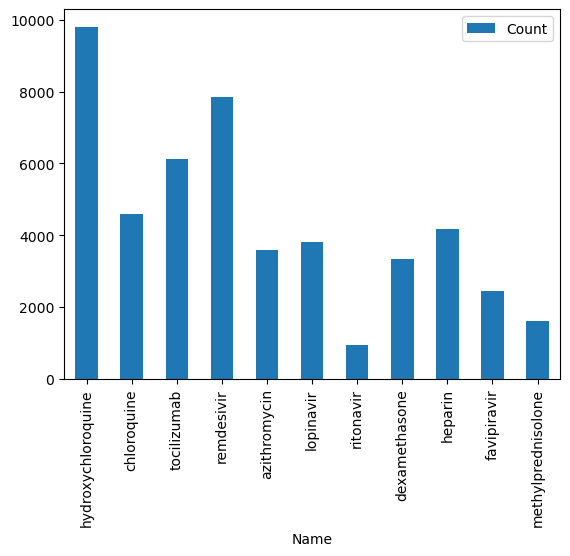

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## চিকিৎসা কৌশলে প্রবণতা খোঁজা

উপরের উদাহরণে আমরা সমস্ত মান `sum` করেছি, তবে আমরা এটি মাসিক ভিত্তিতেও করতে পারি:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

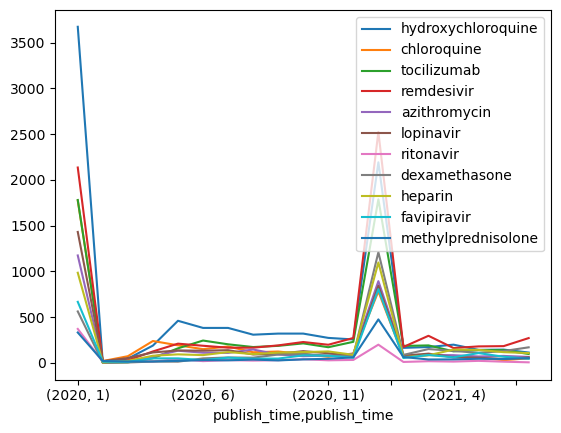

In [152]:
dfmt.plot()
plt.show()

একটি আকর্ষণীয় পর্যবেক্ষণ হলো, আমরা দুটি স্থানে বিশাল বৃদ্ধি লক্ষ্য করি: জানুয়ারি, ২০২০ এবং জানুয়ারি, ২০২১। এটি এই কারণে ঘটে যে কিছু গবেষণাপত্রের প্রকাশনার সুনির্দিষ্ট তারিখ উল্লেখ করা হয়নি, এবং সেগুলো সংশ্লিষ্ট বছরের জানুয়ারি মাস হিসেবে উল্লেখ করা হয়েছে।

তথ্যগুলোকে আরও অর্থবহ করতে, চলুন কেবল কয়েকটি ওষুধের তথ্য চিত্রায়িত করি। আমরা জানুয়ারি মাসের তথ্য "মুছে" ফেলব এবং তা কিছু মাঝারি মান দিয়ে পূরণ করব, যাতে চিত্রটি আরও সুন্দর দেখায়:


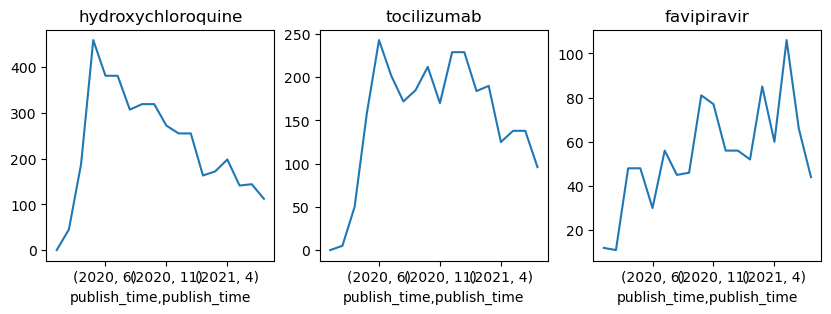

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

হাইড্রোক্সিক্লোরোকুইনের জনপ্রিয়তা প্রথম কয়েক মাসে কীভাবে বৃদ্ধি পাচ্ছিল তা লক্ষ্য করুন, এবং তারপর এটি কমতে শুরু করে, যখন ফ্যাভিপিরাভিরের উল্লেখের সংখ্যা স্থিতিশীল বৃদ্ধি দেখায়। আপেক্ষিক জনপ্রিয়তা চিত্রিত করার আরেকটি ভালো উপায় হল **স্ট্যাক প্লট** (অথবা প্যান্ডাস পরিভাষায় **এরিয়া প্লট**) ব্যবহার করা:


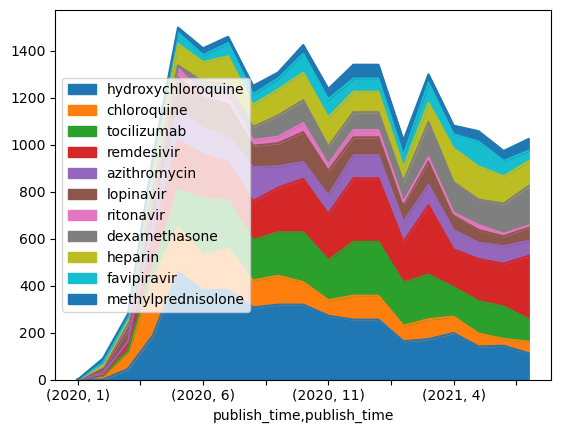

In [154]:
dfmt.plot.area()
plt.show()

এমনকি আরও এগিয়ে, আমরা শতাংশে আপেক্ষিক জনপ্রিয়তা গণনা করতে পারি:


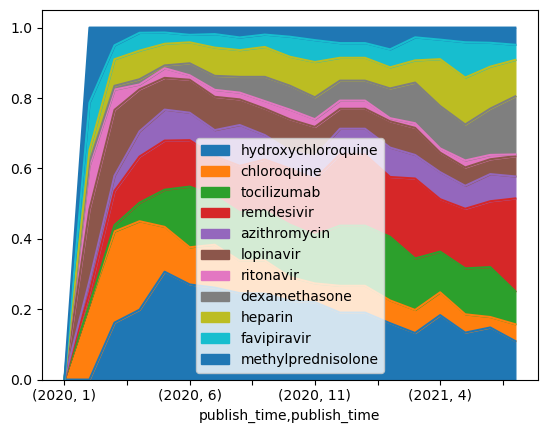

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## চিকিৎসা-নির্ণয়ের সম্পর্ক নির্ধারণ

সবচেয়ে আকর্ষণীয় সম্পর্কগুলোর একটি হলো কীভাবে বিভিন্ন নির্ণয় ভিন্ন ভিন্ন ওষুধ দিয়ে চিকিৎসা করা হয়। এটি দৃশ্যমান করার জন্য, আমাদের **সহ-উপস্থিতির ফ্রিকোয়েন্সি মানচিত্র** গণনা করতে হবে, যা দেখাবে কতবার দুটি শব্দ একই গবেষণাপত্রে উল্লেখ করা হয়েছে।

এই মানচিত্রটি মূলত একটি 2D ম্যাট্রিক্স, যা **numpy array** দিয়ে সবচেয়ে ভালোভাবে উপস্থাপন করা যায়। আমরা এই মানচিত্রটি তৈরি করব সমস্ত সারাংশের (abstracts) মধ্য দিয়ে হাঁটতে হাঁটতে এবং সেখানে উপস্থিত সত্তাগুলো চিহ্নিত করে:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

এই ম্যাট্রিক্সটি চিত্রিত করার একটি উপায় হল একটি **হিটম্যাপ** আঁকা:


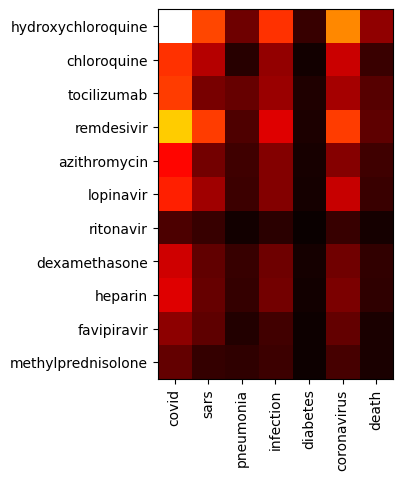

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

তথাকথিত **Sankey** ডায়াগ্রাম ব্যবহার করে আরও ভালো ভিজুয়ালাইজেশন করা সম্ভব! `matplotlib`-এ এই ডায়াগ্রাম টাইপের জন্য বিল্ট-ইন সাপোর্ট নেই, তাই আমাদের [Plotly](https://plotly.com/python/) ব্যবহার করতে হবে, যেমনটি [এই টিউটোরিয়ালে](https://plotly.com/python/sankey-diagram/) বর্ণনা করা হয়েছে।

Plotly Sankey ডায়াগ্রাম তৈরি করতে, আমাদের নিম্নলিখিত তালিকাগুলি তৈরি করতে হবে:
* গ্রাফের সমস্ত নোডের একটি তালিকা `all_nodes`, যা ওষুধ এবং ডায়াগনোসিস উভয়কেই অন্তর্ভুক্ত করবে
* সোর্স এবং টার্গেট ইনডেক্সের তালিকা - এই তালিকাগুলি দেখাবে কোন নোডগুলি ডায়াগ্রামের বাম দিকে যাবে এবং কোনগুলি ডান দিকে যাবে
* সমস্ত লিঙ্কের একটি তালিকা, প্রতিটি লিঙ্কের মধ্যে থাকবে:
   - `all_nodes` অ্যারেতে সোর্স ইনডেক্স
   - টার্গেট ইনডেক্স
   - লিঙ্কের শক্তি নির্দেশকারী মান। এটি আমাদের কো-অকারেন্স ম্যাট্রিক্স থেকে প্রাপ্ত মান।
   - ঐচ্ছিকভাবে লিঙ্কের রঙ। আমরা কিছু টার্মকে স্পষ্টতার জন্য হাইলাইট করার একটি অপশন রাখব

Sankey ডায়াগ্রাম আঁকার জন্য জেনেরিক কোডটি একটি পৃথক `sankey` ফাংশন হিসেবে গঠন করা হয়েছে, যা দুটি তালিকা (সোর্স এবং টার্গেট ক্যাটাগরি) এবং কো-অকারেন্স ম্যাট্রিক্স গ্রহণ করে। এটি আমাদের থ্রেশহোল্ড নির্ধারণ করার অনুমতি দেয় এবং সেই সমস্ত লিঙ্ক বাদ দেয় যেগুলি সেই থ্রেশহোল্ডের চেয়ে দুর্বল - এটি ডায়াগ্রামটিকে কিছুটা কম জটিল করে তোলে।


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## উপসংহার

আপনি দেখেছেন যে আমরা বেশ সহজ পদ্ধতি ব্যবহার করে অগঠিত ডেটা উৎস, যেমন টেক্সট থেকে তথ্য বের করতে পারি। এই উদাহরণে, আমরা বিদ্যমান ওষুধের তালিকা ব্যবহার করেছি, তবে টেক্সট থেকে সত্তা বের করার জন্য প্রাকৃতিক ভাষা প্রক্রিয়াকরণ (NLP) কৌশল ব্যবহার করা আরও শক্তিশালী হবে। [এই ব্লগ পোস্টে](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) আমরা ক্লাউড পরিষেবাগুলি ব্যবহার করে সত্তা বের করার পদ্ধতি বর্ণনা করেছি। আরেকটি বিকল্প হতে পারে Python NLP লাইব্রেরি যেমন [NLTK](https://www.nltk.org/) ব্যবহার করা - NLTK ব্যবহার করে টেক্সট থেকে তথ্য বের করার একটি পদ্ধতি [এখানে](https://www.nltk.org/book/ch07.html) বর্ণনা করা হয়েছে।


## চ্যালেঞ্জ

COVID পেপারের ডেটা নিয়ে নিম্নলিখিত দিকগুলোতে গবেষণা চালিয়ে যান:

1. বিভিন্ন ওষুধের সহ-উপস্থিতি ম্যাট্রিক্স তৈরি করুন এবং দেখুন কোন ওষুধগুলো প্রায়ই একসাথে উপস্থিত হয় (অর্থাৎ, একটি অ্যাবস্ট্রাক্টে উল্লেখিত)। ওষুধ এবং রোগ নির্ণয়ের জন্য সহ-উপস্থিতি ম্যাট্রিক্স তৈরির কোডটি পরিবর্তন করতে পারেন।
1. এই ম্যাট্রিক্সটি হিটম্যাপ ব্যবহার করে ভিজুয়ালাইজ করুন।
1. একটি অতিরিক্ত লক্ষ্য হিসেবে, ওষুধের সহ-উপস্থিতি [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram) ব্যবহার করে ভিজুয়ালাইজ করার চেষ্টা করতে পারেন। [এই লাইব্রেরি](https://pypi.org/project/chord/) আপনাকে একটি chord diagram আঁকতে সাহায্য করতে পারে।
1. আরেকটি অতিরিক্ত লক্ষ্য হিসেবে, বিভিন্ন ওষুধের ডোজ (যেমন **400mg** *প্রতিদিন 400mg chloroquine নিন* এর মতো) নিয়মিত এক্সপ্রেশন ব্যবহার করে বের করার চেষ্টা করুন এবং একটি ডেটাফ্রেম তৈরি করুন যা বিভিন্ন ওষুধের জন্য বিভিন্ন ডোজ দেখায়। **নোট**: ওষুধের নামের কাছাকাছি টেক্সটের মধ্যে থাকা সংখ্যাগত মানগুলো বিবেচনা করুন।



---

**অস্বীকৃতি**:  
এই নথিটি AI অনুবাদ পরিষেবা [Co-op Translator](https://github.com/Azure/co-op-translator) ব্যবহার করে অনুবাদ করা হয়েছে। আমরা যথাসম্ভব সঠিক অনুবাদের চেষ্টা করি, তবে অনুগ্রহ করে মনে রাখবেন যে স্বয়ংক্রিয় অনুবাদে ত্রুটি বা অসঙ্গতি থাকতে পারে। নথিটির মূল ভাষায় থাকা সংস্করণটিকেই প্রামাণিক উৎস হিসেবে বিবেচনা করা উচিত। গুরুত্বপূর্ণ তথ্যের জন্য পেশাদার মানব অনুবাদ ব্যবহার করার পরামর্শ দেওয়া হচ্ছে। এই অনুবাদ ব্যবহারের ফলে সৃষ্ট কোনো ভুল বোঝাবুঝি বা ভুল ব্যাখ্যার জন্য আমরা দায়ী নই।
